In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import fcwt
# Read EDF+ file
def read_edf_file(file_path):
    # Read the EDF+ file
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Get annotations/markers
    annotations = raw.annotations
    print(annotations)
    
    # Convert annotations to DataFrame
    markers_df = pd.DataFrame({
        'Onset': annotations.onset,
        'Duration': annotations.duration,
        'Description': annotations.description
    })
    
    # Get signal data
    data = raw.get_data()    
    return data, markers_df, raw.info['sfreq']

# Write markers to file
def write_markers(markers_df, output_file):
    markers_df.to_csv(output_file, index=False)


def create_intervals(df):
    intervals = {'ds': [], 'is': [], 'swd': []}
    
    # Initialize variables to track start times
    current_starts = {'ds': None, 'is': None, 'swd': None}
    
    # Iterate through the dataframe rows
    for index, row in df.iterrows():
        event_type = row['Description'][:-1]  # Remove the last character (1 or 2)
        event_number = int(row['Description'][-1])  # Get the last character as number
        
        if event_type in ['ds', 'is', 'swd']:
            if event_number == 1:  # Start of interval
                current_starts[event_type] = row['Onset']
            elif event_number == 2:  # End of interval
                if current_starts[event_type] is not None:
                    intervals[event_type].append((current_starts[event_type], row['Onset']))
                    current_starts[event_type] = None
    
    return intervals


# Function to merge overlapping intervals
def merge_intervals(intervals):
    merged = []
    for interval in intervals:
        if not merged:
            merged.append(interval)
        else:
            prev = merged[-1]
            if interval[0] <= prev[1]:
                merged[-1] = (prev[0], max(prev[1], interval[1]))
            else:
                merged.append(interval)
    return merged


# Compute complement intervals for 'normal' class
def compute_complement_intervals(intervals, total_duration):
    complement = []
    prev_end = 0
    for start, end in intervals:
        if start > prev_end:
            complement.append((prev_end, start))
        prev_end = end
    if prev_end < total_duration:
        complement.append((prev_end, total_duration))
    return complement

In [2]:
import os

only_files = [f for f in os.listdir('full_data/') if ".edf" in f.lower()]
only_files

['Ati4x1_15m_BL_6h_edited.edf',
 'Ati4x1_15m_BL_6h_fully_marked.edf',
 'Ati4x1_15m_Dex003(Pharm!)_6h_fully_marked.edf',
 'Ati4x1_15m_H2O_6h_edited.edf',
 'Ati4x1_15m_H2O_6h_fully_marked.edf',
 'Ati4x3B_15m_H2O_6h_edited.edf',
 'Ati4x3_12m_BL_6h_edited.edf',
 'Ati4x3_12m_BL_6h_fully_marked.edf',
 'Ati4x3_9m_Xyl01(Pharm!)_6h_fully_marked.edf',
 'Ati4x6_14m_BL_6h_edited.edf',
 'Ati4x6_14m_BL_6h_fully_marked.edf',
 'Ati4x6_14m_H2O_6h_edited.edf',
 'Ati4x7_14m_BL_6h_edited.edf',
 'Ati4y2_11m_BL_6h_edited.edf',
 'Ati4y3_12m_BL_6h_edited.edf',
 'Ati4y4_12m_BL_6h_edited.edf',
 'Ati4y4_13m_BL_6h_edited.edf',
 'Ati5x1_10m_BL_6h_edited.edf',
 'Ati5x1_11m_BL_6h_edited.edf',
 'Ati5x2_12m_BL_6h_edited.edf',
 'Ati5x3_14m_BL_6h_edited.edf']

In [3]:
# Assuming 'data' is your numpy array of shape (3, 400 * seconds)
# For the sake of example, let's define seconds and sampling rate
seconds = 21600
sampling_rate = 400  # Hz
total_samples = seconds * sampling_rate
channels = 3  # Number of channels in data
window_duration = 2  # seconds
window_size = int(window_duration * sampling_rate)  # Number of samples in a window
full_measurements = []
full_labels = []

for file in only_files:
    data, markers, fs = read_edf_file(os.path.join('full_data/',file))
    intervals = create_intervals(markers)
    print(intervals)

    # Collect all intervals from 'ds', 'is', 'swd'
    all_intervals = []
    for class_name in ['ds', 'is', 'swd']:
        all_intervals.extend(intervals[class_name])
    
    # Sort intervals by start time
    all_intervals.sort(key=lambda x: x[0])
    
    
    merged_intervals = merge_intervals(all_intervals)
    
    
    total_time = seconds  # Total measurement duration
    normal_intervals = compute_complement_intervals(merged_intervals, total_time)
    intervals['normal'] = normal_intervals

    measurements = {}
    labels = []
    labels_present = []
    
    for class_name in ['ds', 'is', 'swd', 'normal']:
        indices_list = []
        for start_time, end_time in intervals[class_name]:
            min_idx = int(np.ceil(start_time * sampling_rate))
            max_idx = int(np.floor(end_time * sampling_rate) - window_size + 1)
            if max_idx >= min_idx:
                indices = np.arange(min_idx, max_idx + 1)
                indices_list.append(indices)
        if indices_list:
            all_indices = np.concatenate(indices_list)
            # Sample 2000 indices
            if len(all_indices) >= 1000:
                sampled_indices = np.random.choice(all_indices, 1000, replace=False)
            else:
                sampled_indices = all_indices
                print('OVERSAMPLED')
                print(len(all_indices))
                print('OVERSAMPLED')
            # Extract measurements
            class_measurements = np.array([
                data[:, idx:idx + window_size] for idx in sampled_indices
            ])
            measurements[class_name] = class_measurements
            labels.extend([class_name] * len(sampled_indices))
            labels_present.append(class_name)
        else:
            print(f"No valid measurements found for class {class_name}")
        # Combine datafrom all classes
    all_measurements = np.concatenate([measurements[class_name] for class_name in labels_present], axis=0)
    # Convert labels to numeric classes if needed
    label_map = {'ds': 0, 'is': 1, 'swd': 2, 'normal': 3}
    numeric_labels = np.array([label_map[label] for label in labels])

    full_measurements.extend(all_measurements)
    full_labels.extend(numeric_labels)

Extracting EDF parameters from /media/kglin/NewData/Hack-ECG/full_data/Ati4x1_15m_BL_6h_edited.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8640399  =      0.000 ... 21600.998 secs...
<Annotations | 12 segments: ds1 (3), ds2 (3), is1 (3), is2 (3)>
{'ds': [(223.725, 261.9375), (1722.675, 1771.9875), (7459.225, 7516.7125)], 'is': [(1772.3, 1790.55), (7813.406493, 7828.546472), (9128.025, 9161.1125)], 'swd': []}
No valid measurements found for class swd
Extracting EDF parameters from /media/kglin/NewData/Hack-ECG/full_data/Ati4x1_15m_BL_6h_fully_marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8640399  =      0.000 ... 21600.998 secs...
<Annotations | 138 segments: ds1 (57), ds2 (57), is1 (12), is2 (12)>
{'ds': [(178.0, 262.0), (343.0, 496.0), (1475.0, 1501.0), (1511.0, 1772.0), (2003.0, 2246.0), (2255.0, 2288.0), (2317.0, 2356.0), (2437.0, 2519.0), (2581.0, 2636.0), (2

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import fcwt  # Ensure this package is installed
from scipy.signal import resample
import torchvision.transforms as transforms



# Parameters for CWT
fs = 400  # Sampling frequency
f0 = 1    # Lowest frequency
f1 = 21   # Highest frequency
fn = 80   # Number of frequencies (output will be 80 frequency bins)
output_time_samples = 80  # Desired number of time samples after resampling

# Assuming full_measurements and full_labels are already defined
# full_measurements shape: (N_samples, 3, 800)
# full_labels shape: (N_samples,)

full_measurements = np.array(full_measurements)
N_samples = full_measurements.shape[0]
transformed_data = np.zeros((N_samples, 3, fn, output_time_samples), dtype=np.float32)

# Use tqdm to monitor the speed
for i in tqdm(range(N_samples), desc='Processing EEG Samples'):
    for ch in range(3):
        signal = full_measurements[i, ch, :]  # Shape: (800,)
        # Compute the CWT
        freqs, cwt_output = fcwt.cwt(signal, fs, f0, f1, fn)
        # cwt_output shape: (fn, signal_length)
        # Resample time axis to desired number of samples
        cwt_resampled = resample(cwt_output, output_time_samples, axis=1)
        # Compute magnitude and apply decibel transform
        magnitude = np.abs(cwt_resampled)
        decibel = 10 * np.log10(magnitude + 1e-6)  # Add small value to avoid log(0)
        # Store the transformed data
        transformed_data[i, ch] = decibel


Processing EEG Samples: 100%|████████████| 66000/66000 [01:06<00:00, 993.14it/s]


In [5]:
# Scale data to [0, 1]
global_min = transformed_data.min()
global_max = transformed_data.max()
transformed_data = (transformed_data - global_min) / (global_max - global_min)

In [6]:
# Define ImageNet normalization values
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

# Since our data has 3 channels, we can apply the normalization per channel
# Note: The mean and std are broadcasted to match the data shape
transformed_data_normalized = (transformed_data - imagenet_mean[:, None, None]) / imagenet_std[:, None, None]

In [18]:
class TransformedEEGDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): Transformed EEG data of shape (N_samples, 3, 64, 80)
            labels (numpy array): Labels of shape (N_samples,)
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the image and label
        image = self.data[idx]  # Shape: (3, 64, 80)
        label = self.labels[idx]
        
        # Apply transforms if any
        if self.transform:
            # torchvision transforms expect (C, H, W)
            image = torch.tensor(image, dtype=torch.float32)
            image = self.transform(image)

        return image, label

In [16]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/kglin/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:02<00:00, 7.19MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import fcwt
from scipy.signal import resample
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import AUROC, Accuracy, F1Score
import torchvision.models as models
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
# ------------------------ 4. Train/Validation Split ------------------------

# Define transforms: Resize to 224x224 as EfficientNet expects larger images
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    # No need to normalize again as data is already normalized
    # If using PIL Images, ensure correct format
])

# Create the dataset
dataset = TransformedEEGDataset(transformed_data_normalized, full_labels, transform=data_transforms)

# Define train/validation split ratio
train_ratio = 0.8
val_ratio = 0.2
assert train_ratio + val_ratio == 1.0, "Train and validation ratios must sum to 1."

# Calculate lengths
train_length = int(train_ratio * len(dataset))
val_length = len(dataset) - train_length

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# ------------------------ 5. Define the Lightning Module ------------------------

class EfficientNetEEGClassifier(pl.LightningModule):
    def __init__(self, num_classes=4, learning_rate=1e-3):
        super().__init__()
        
        self.save_hyperparameters()  # Saves hyperparameters to checkpoints
        
        # Load pre-trained EfficientNet (e.g., EfficientNet-B0)
        self.model = models.efficientnet_b0(pretrained=True)
        
        # Modify the classifier head
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)
        
        # Metrics
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.val_auroc = AUROC(task="multiclass", num_classes=num_classes, average='macro')
        
        # Class weights (ensure they're on the correct device in training_step)
        self.register_buffer('class_weights', torch.tensor([
            4.0,    # class 0
            4.0,    # class 1
            4.0,    # class 2
            1.0     # class 3 (normal)
        ]))
        
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_accuracy"
        }
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # Move class_weights to the same device as logits
        class_weights = self.class_weights.to(logits.device)
        
        # Weighted cross-entropy loss
        loss = F.cross_entropy(logits, y, weight=class_weights)
        
        # Predictions
        preds = torch.argmax(logits, dim=1)
        
        # Metrics
        acc = self.train_accuracy(preds, y)
        f1 = F1Score(task="multiclass", num_classes=self.hparams.num_classes, average='macro').to(logits.device)(preds, y)
        
        # Logging
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_f1', f1, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        class_weights = self.class_weights.to(logits.device)
        
        # Weighted cross-entropy loss
        loss = F.cross_entropy(logits, y, weight=class_weights)
        
        # Predictions
        preds = torch.argmax(logits, dim=1)
        probs = F.softmax(logits, dim=1)
        
        # Metrics
        acc = self.val_accuracy(preds, y)
        f1 = self.val_f1(preds, y)
        auroc = self.val_auroc(probs, y)
        
        # Logging
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_accuracy', acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_f1', f1, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_auroc', auroc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss


Training samples: 52800
Validation samples: 13200


In [30]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 1650
Number of validation batches: 413


In [31]:
# Initialize the model
num_classes = 4  # Update as per your dataset
learning_rate = 1e-3
model = EfficientNetEEGClassifier(num_classes=num_classes, learning_rate=learning_rate)

torch.set_float32_matmul_precision('medium')

# Initialize TensorBoard logger
logger = TensorBoardLogger("tb_logs", name="efficientnet_eeg")

# Initialize Model Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='checkpoints',
    filename='efficientnet-eeg-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,
    mode='max',
)

# Initialize Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=True
)

# Initialize Trainer
trainer = pl.Trainer(
    max_epochs=100,
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping],
)

# Start training
trainer.fit(model, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | EfficientNet       | 4.0 M 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | val_f1         | MulticlassF1Score  | 0     
4 | val_auroc      | MulticlassAUROC    | 0     
------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.051    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

Training: |                                               | 0/? [00:00<?, ?it/s]

/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

Validation: |                                             | 0/? [00:00<?, ?it/s]

/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Metric val_accuracy improved. New best score: 0.843
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weigh

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.853
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the r

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.873
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the r

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.879
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the r

Validation: |                                             | 0/? [00:00<?, ?it/s]

/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.887
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kglin/miniconda3/envs/chanpred/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the r

In [44]:
freqs, cwt_output = fcwt.cwt(signal, 400, 1, 21, 80)


In [45]:
# Parameters for CWT


output_time_samples = 80  # Desired number of time samples after resampling
inference_data, inference_markers, _ = read_edf_file('to-classify/TEST1_30min.edf')
inference_data = inference_data[:,:]

inference_batch = inference_data.reshape(3,-1,800).transpose(1,0,2)
N_inference = inference_batch.shape[0]
transformed_data_inference = np.zeros((N_inference, 3, fn, output_time_samples), dtype=np.float32)

fs = 400  # Sampling frequency
f0 = 1    # Lowest frequency
f1 = 21   # Highest frequency
fn = 80   # Number of frequencies (output will be 80 frequency bins)

# Use tqdm to monitor the speed
for i in tqdm(range(N_inference), desc='Processing EEG Samples'):
    for ch in range(3):
        signal = inference_batch[i, ch, :]  # Shape: (800,)
        # Compute the CWT
        freqs, cwt_output = fcwt.cwt(signal, fs, f0, f1, fn)
        # cwt_output shape: (fn, signal_length)
        # Resample time axis to desired number of samples
        cwt_resampled = resample(cwt_output, output_time_samples, axis=1)
        # Compute magnitude and apply decibel transform
        magnitude = np.abs(cwt_resampled)
        decibel = 10 * np.log10(magnitude + 1e-6)  # Add small value to avoid log(0)
        # Store the transformed data
        transformed_data_inference[i, ch] = decibel

Extracting EDF parameters from /media/kglin/NewData/Hack-ECG/to-classify/TEST1_30min.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 719999  =      0.000 ...  1799.997 secs...
<Annotations | 0 segments>



Processing EEG Samples: 100%|████████████████| 900/900 [00:00<00:00, 976.85it/s]


In [48]:
# Scale data to [0, 1]
global_min = transformed_data_inference.min()
global_max = transformed_data_inference.max()
transformed_data = (transformed_data_inference - global_min) / (global_max - global_min)

# Define ImageNet normalization values
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

# Since our data has 3 channels, we can apply the normalization per channel
# Note: The mean and std are broadcasted to match the data shape
transformed_data_normalized = (transformed_data - imagenet_mean[:, None, None]) / imagenet_std[:, None, None]

In [56]:
transform = transforms.Resize((128, 128))
inference_dataset = TransformedEEGDataset(transformed_data_normalized,[0]*len(transformed_data_normalized), transform=transform)
    
    # Step 3: Create the DataLoader
inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False, num_workers=4)
    

In [60]:
inference_dataset[0]

(tensor([[[-0.6036, -0.8666, -1.2040,  ..., -0.4990, -0.5172, -0.5297],
          [-0.6024, -0.8627, -1.1965,  ..., -0.4834, -0.5047, -0.5194],
          [-0.6008, -0.8578, -1.1872,  ..., -0.4613, -0.4871, -0.5050],
          ...,
          [-1.1972, -0.9230, -0.5794,  ..., -0.3280, -0.2770, -0.2338],
          [-1.1290, -1.0069, -0.8549,  ..., -0.5878, -0.5483, -0.5146],
          [-1.0659, -1.0759, -1.0902,  ..., -0.8213, -0.7924, -0.7677]],
 
         [[-0.7574, -0.6260, -0.4487,  ..., -0.2607, -0.2827, -0.2995],
          [-0.7445, -0.6050, -0.4172,  ..., -0.2369, -0.2601, -0.2777],
          [-0.7271, -0.5761, -0.3735,  ..., -0.2032, -0.2280, -0.2469],
          ...,
          [-0.2952, -0.0158,  0.3349,  ...,  0.4277,  0.4871,  0.5369],
          [-0.6441, -0.5043, -0.3323,  ...,  0.0169,  0.0698,  0.1143],
          [-0.9406, -0.9253, -0.9124,  ..., -0.3535, -0.3075, -0.2687]],
 
         [[-0.1168, -0.1498, -0.1922,  ..., -0.3599, -0.3412, -0.3272],
          [-0.1050, -0.1351,

In [69]:
ys = []
with torch.no_grad():
    for i in range(transformed_data_normalized.shape[0]):
        ys.append(model(inference_dataset[i][0].unsqueeze(0)))

In [72]:
y_max = np.argmax(ys,axis = -1).flatten()


array([3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 0, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3,
       0, 1, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 3, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 3, 3, 1, 0, 3, 2,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 3, 2, 3,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 2, 2, 3, 3, 0, 3, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,

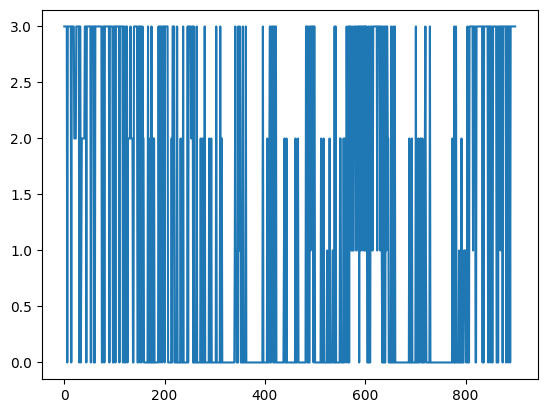

In [73]:
plt.plot(y_max)